##Libraries/Modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils import paths
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from collections import defaultdict

##Dataset

In [2]:
class MyDataset(Dataset):

  def __init__(self, data_dir, is_train):
    super().__init__()
    self.data_dir = data_dir
    self.is_train = is_train

    input_dir = Path(data_dir).joinpath('input')
    gt_dir = Path(data_dir).joinpath('gt')

    input_imgs = sorted(list(paths.list_images(input_dir)))
    gt_imgs = sorted(list(paths.list_images(gt_dir)))
        
    self.pair_images = list(zip(input_imgs, gt_imgs))

  def __len__(self):
    return len(self.pair_images)

  def __getitem__(self, idx):
    img_path, gt_path = self.pair_images[idx]
    img = cv2.imread(str(img_path))
    gt = cv2.imread(str(gt_path))

    img = np.transpose(img, axes=(2, 0, 1)) / 255.
    gt = np.transpose(gt, axes=(2, 0, 1)) / 255.

    img = torch.from_numpy(img).float()
    gt = torch.from_numpy(gt).float()
    return (img, gt)

##Network

In [3]:
class AdaptiveBatchNorm2d(nn.Module):    

  def __init__(self, num_feat, eps=1e-5, momentum=0.1, affine=True):        
    super().__init__()
    self.bn = nn.BatchNorm2d(num_feat, eps, momentum, affine)
    self.a = nn.Parameter(torch.ones(1, 1, 1, 1))
    self.b = nn.Parameter(torch.zeros(1, 1, 1, 1))

  def forward(self, x):
    return self.a * x + self.b * self.bn(x)

In [4]:
class ConvBlock(nn.Module):    

  def __init__(self, in_channels, out_channels, kernel_size, padding, dilation, norm_layer=AdaptiveBatchNorm2d):                              
    super().__init__()
    conv_block = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, dilation=dilation),
                  norm_layer(out_channels) if norm_layer is not None else nn.Identity(),
                  nn.LeakyReLU(negative_slope=0.2)
                  ]
    self.conv_block = nn.Sequential(*conv_block)
    self.init_weights(self.conv_block)

  def identity_init(self, shape):
    array = np.zeros(shape, dtype=float)
    cx, cy = shape[2] // 2, shape[3] // 2
    for i in range(np.minimum(shape[0], shape[1])):
      array[i, i, cx, cy] = 1
    return array

  def init_weights(self, modules):
    for m in modules:
      if isinstance(m, nn.Conv2d):
        weights = self.identity_init(m.weight.shape)
        with torch.no_grad():
            m.weight.copy_(torch.from_numpy(weights).float())
        torch.nn.init.zeros_(m.bias)

  def forward(self, *inputs):
    return self.conv_block(inputs[0])

In [5]:
class CAN24(nn.Module):    

  def __init__(self):        
    super().__init__()
    w = 24
    self.conv1 = ConvBlock(3, w, 3, 1, 1)
    self.conv2 = ConvBlock(w, w, 3, 2, 2)
    self.conv3 = ConvBlock(w, w, 3, 4, 4)
    self.conv4 = ConvBlock(w, w, 3, 8, 8)
    self.conv5 = ConvBlock(w, w, 3, 16, 16)
    self.conv6 = ConvBlock(w, w, 3, 32, 32)
    self.conv7 = ConvBlock(w, w, 3, 64, 64)
    self.conv8 = ConvBlock(w, w, 3, 1, 1)
    self.conv9 = nn.Conv2d(w, 3, kernel_size=1, dilation=1)
    self.weights_init(self.conv9)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.conv8(x)
    x = self.conv9(x)

    return x

  def weights_init(self, m):        
    if isinstance(m, nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight)
      torch.nn.init.zeros_(m.bias)

##Trainer

In [6]:
class Model(nn.Module):

  def __init__(self, data_dir, batch_size, num_workers=2, lr=1e-4):
    super().__init__()
    self.model = CAN24()
    self.hparams = {}
    self.hparams['data_dir'] = data_dir
    self.hparams['batch_size'] = batch_size
    self.hparams['num_workers'] = num_workers
    self.hparams['lr'] = lr

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr=self.hparams['lr'], eps=1e-7)

  def train_dataloader(self):
    train_dir = Path(self.hparams['data_dir']).joinpath('train')
    self.train_data = MyDataset(train_dir, is_train=True)
    train_dl = DataLoader(self.train_data, batch_size=self.hparams['batch_size'], shuffle=True, num_workers=self.hparams['num_workers'])
    return train_dl

  def val_dataloader(self):
    val_dir = Path(self.hparams['data_dir']).joinpath('val')
    self.val_data = MyDataset(val_dir, is_train=False)
    val_dl = DataLoader(self.val_data, batch_size=self.hparams['batch_size'], shuffle=False, num_workers=self.hparams['num_workers'])
    return val_dl

  def training_step(self, batch):
    x, y = batch
    y_hat = self(x)
    loss = F.mse_loss(y_hat, y, reduction='mean')
    return loss

  def validation_step(self, batch):
    x, y = batch
    y_hat = self(x)
    loss = F.mse_loss(y_hat, y, reduction='mean')
    return loss   

In [7]:
class Trainer:

  def __init__(self, device, max_epochs):
    self.device = device
    self.max_epochs = max_epochs
    self.loss_log = defaultdict(list)
    
  def prepare_model(self, model):
    model = model.to(self.device)
    self.model = model

  def prepare_batch(self, batch):
    batch = [a.to(self.device) for a in batch]
    return batch

  def fit(self, model):
    self.prepare_model(model)    
    self.train_dataloader = model.train_dataloader()
    self.val_dataloader = model.val_dataloader()
    self.optim = model.configure_optimizers()    

    self.epoch = 0    
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()      
      # print(self.loss_log)

  def fit_epoch(self):
    self.model.train()
    train_losses = []    
    for batch in self.train_dataloader:
      loss = self.model.training_step(self.prepare_batch(batch))
      self.optim.zero_grad()
      with torch.no_grad():
        loss.backward()        
        self.optim.step()          
      train_losses.append(loss)
    self.loss_log['Train loss'].append(torch.stack(train_losses).mean().item())
    
    if self.val_dataloader is None:
      return

    self.model.eval()
    val_losses = []
    for batch in self.val_dataloader:
      with torch.no_grad():
        loss = self.model.validation_step(self.prepare_batch(batch))      
      val_losses.append(loss)
    self.loss_log['Val loss'].append(torch.stack(val_losses).mean().item())      

##Training

In [8]:
data_dir = '/content/drive/MyDrive/M.Tech CS_2022-23/Deep Learning/SUMMATIVE TEST/data/'

In [9]:
model = Model(data_dir, batch_size=1)
trainer = Trainer(device='cuda', max_epochs=5)
trainer.fit(model)

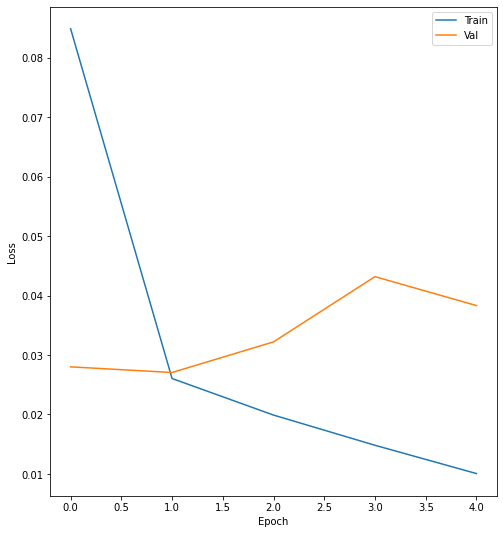

In [10]:
plt.figure(figsize=(8,9))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(trainer.loss_log['Train loss'], label='Train')
plt.plot(trainer.loss_log['Val loss'], label='Val')
plt.legend()
plt.show()

##Testing

In [ ]:
test_dir = Path(data_dir).joinpath('test')

input_dir = Path(test_dir).joinpath('input')
gt_dir = Path(test_dir).joinpath('gt')
result_dir = Path(test_dir).joinpath('result')

input_imgs = sorted(list(paths.list_images(input_dir)))
gt_imgs = sorted(list(paths.list_images(gt_dir)))
result_imgs = sorted(list(paths.list_images(result_dir)))

In [ ]:
def get_output(img_path, model):
  data = cv2.imread(img_path)
  data = np.transpose(data, [2, 0, 1]) / 255.
  data = torch.tensor(data).unsqueeze(0) 
  data = data.float()

  output = model(data.cuda()).squeeze().detach().cpu().numpy()    

  output = np.transpose(output, [1, 2, 0])
  output = np.clip(output, 0, 1)
  output = output * 255
  output = output.astype(np.uint8)

  return output


model.eval()

for img_path in input_imgs:
  out_name = Path(img_path).stem + '.png'    
  out_path = str(Path(result_dir).joinpath(out_name))
  out = get_output(img_path, model)
  cv2.imwrite(out_path, out)

Input				GroundTruth				Output


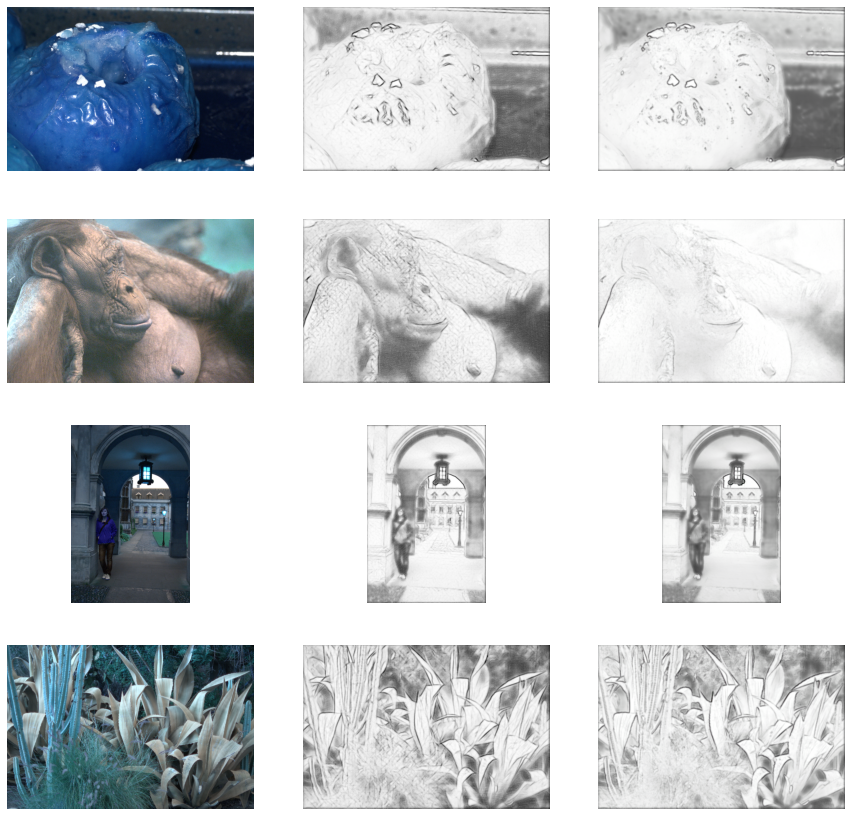

In [ ]:
import random
    
images = list(zip(input_imgs, gt_imgs, result_imgs))
rand_idx = random.sample(range(50), 4)

print("Input\t\t\t\tGroundTruth\t\t\t\tOutput")
fig, ax = plt.subplots(4, 3, figsize=(15,15))

for i, idx in enumerate(rand_idx):
  input_path, gt_path, result_path = images[idx]
  input = cv2.imread(str(input_path))
  gt = cv2.imread(str(gt_path))
  result = cv2.imread(str(result_path))
    
  ax[i][0].imshow(input)
  ax[i][0].axis('off')
  ax[i][1].imshow(gt)
  ax[i][1].axis('off')
  ax[i][2].imshow(result)
  ax[i][2].axis('off')

plt.show()

##Accuracy

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import pandas as pd

pair_images = list(zip(result_imgs, gt_imgs))

PSNR = []
SSIM = []

for result_path, gt_path in pair_images:
  result = cv2.imread(str(result_path)) / 255.
  gt = cv2.imread(str(gt_path)) / 255. 
  PSNR.append(psnr(gt, result))
  SSIM.append(ssim(gt, result, multichannel=True))

scores = pd.DataFrame()
scores['PSNR'] = PSNR
scores['SSIM'] = SSIM

filename = str(test_dir) + ' scores.csv'
scores.to_csv(filename)